In [2]:
import json 
import numpy as np
import cPickle as pkl
from io import BytesIO
import urllib
import tempfile
import os
import subprocess

In [3]:
ref_img_embs = pkl.load(open("results/img_embeds.pkl"))
ref_img_ids = pkl.load(open("results/img_ids.pkl"))

In [4]:
ref_rec_embs = pkl.load(open("results/rec_embeds.pkl"))
ref_rec_ids = pkl.load(open("results/rec_ids.pkl"))

In [5]:
def load_layer1_json(rec_ids):
    recid2recjs = {}
    with open("../data/layer1.json") as f:
        f.readline()
        for i, line in enumerate(f):
            line = line.strip()[:-1]
            if not line:
                break
            try:
                js_dict = json.loads(line)
                rec_id= js_dict['id']
                if rec_id in rec_ids:
                    recid2recjs[rec_id] = js_dict
                if i % 100000 == 0:
                    print i, len(recid2recjs)
            except:
                print line
                continue
    return recid2recjs
            
    

In [6]:
recid2recjs = load_layer1_json(set(list(ref_rec_ids)))

0 0
100000 5041
200000 10103
300000 15188
400000 20123
500000 25206
600000 30164
700000 35164
800000 40049
900000 45040
1000000 49917
{"ingredients": [{"text": "8 cups water"}, {"text": "2/3 cup packed light brown sugar"}, {"text": "1 teaspoon molasses"}, {"text": "2 (3-inch) cinnamon sticks"}, {"text": "1 cup medium-grind coffee (not espresso)"}], "url": "http://www.epicurious.com/recipes/food/views/mexican-style-sweetened-black-coffee-cafe-de-olla-233034", "partition": "train", "title": "Mexican-Style Sweetened Black Coffee (Cafe de Olla)", "id": "ffffdea29a", "instructions": [{"text": "Bring water, brown sugar, molasses, and cinnamon sticks to a boil in a 4-quart pot over moderate heat, stirring occasionally until sugar is dissolved."}, {"text": "Stir in coffee and boil 5 minutes."}, {"text": "Pour through a fine-mesh sieve into a heatproof pitcher or clean pot, discarding coffee grinds and cinnamon sticks."}]


In [95]:
def load_detected_ingredients(rec_ids):
    recid2ing = {}
    with open("../data/det_ingrs.json") as f:
        ing_jsdict = json.load(f)
        for item in ing_jsdict:
            rec_id = item['id']
            if rec_id in rec_ids:
                recid2ing[rec_id] = item
            
    return recid2ing
    

In [96]:
recid2ing = load_detected_ingredients(set(list(ref_rec_ids)))

In [ ]:
vocab = {}
for v in recid2ing.values():
    for ing in v['ingredients']:
        

In [304]:
url = "https://d9hyo6bif16lx.cloudfront.net/live/img/production/detail/menu/lunch-dinner_soups-salads_grilled-chicken-caesar-salad.jpg"

In [305]:
temp_name = next(tempfile._get_candidate_names())
if not os.path.exists("./tmpdir/"):
    os.makedirs("./tmpdir/")
img_path = "./tmpdir/{}.jpg".format(temp_name)
urllib.urlretrieve(url, img_path)

('./tmpdir/KFxcGC.jpg', <httplib.HTTPMessage instance at 0x7f40d0a4be60>)

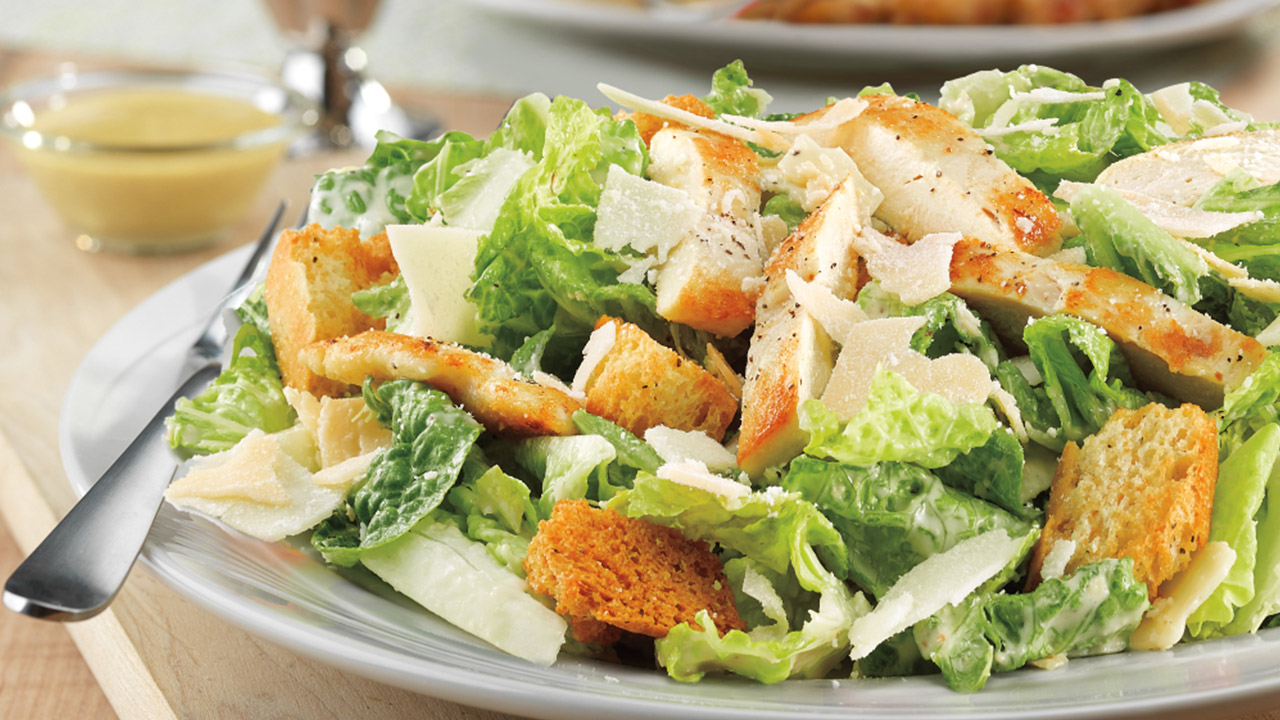

In [306]:
from IPython.display import Image
Image(filename=img_path) 

In [307]:
cmd = "/opt/anaconda3/envs/mochi/bin/python /mochi/im2recipe-Pytorch/img_feature_extractor.py --img_path {0} --model_path /mochi/data/model_e500_v-8.950.pth.tar --no-cuda".format(img_path)
print cmd
ps = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE)
for line in ps.stdout:
    print line
ps.wait()

/opt/anaconda3/envs/mochi/bin/python /mochi/im2recipe-Pytorch/img_feature_extractor.py --img_path ./tmpdir/KFxcGC.jpg --model_path /mochi/data/model_e500_v-8.950.pth.tar --no-cuda
=> loading checkpoint '/mochi/data/model_e500_v-8.950.pth.tar'

=> loaded checkpoint '/mochi/data/model_e500_v-8.950.pth.tar' (epoch 500)



0

In [308]:
img_emb = pkl.load(open("results/extrated_img_embeds.pkl"))

In [309]:
# img 2 rec
sims = np.dot(img_emb, ref_rec_embs.T)

In [310]:
sorting = np.argsort(sims[0])[::-1].tolist()

In [311]:
# read top10 recipes
ing_votes = {}
token2ing = {}
for i in range(10):
    idx = sorting[i]
    rec_id = ref_rec_ids[idx]
    ing = recid2ing[rec_id]
    for i, t in enumerate(ing['ingredients']):
        if not ing['valid'][i]:
            continue
        ing_name = t["text"]
        ing_tokens = [ing_name]
        for token in ing_tokens:
            ing_votes[token] = ing_votes.get(token, 0) + 1
            if token not in token2ing:
                token2ing[token] = []
            token2ing[token].append(ing_name)

res = sorted([(v, token) for token, v in ing_votes.items()], reverse=True)

for i, (v, token) in enumerate(res):
    if v <= 1:
        break
    print "Voted{}: {}, {} votes".format(i+1, token, v)
print ""
    
for i in range(5):
    print "==== TOP {}====".format(i + 1)
    idx = sorting[i]
    rec_id = ref_rec_ids[idx]
    rec = recid2recjs[rec_id]
    print rec['title']
    
    ing = recid2ing[rec_id]
    print "Ingredients:",
    for i, t in enumerate(ing['ingredients']):
        if ing['valid'][i]:
            print t["text"] + ",",
    print ""
    print ""

Voted1: romaine lettuce, 10 votes
Voted2: parmesan cheese, 8 votes
Voted3: garlic clove, 6 votes
Voted4: croutons, 6 votes
Voted5: olive oil, 5 votes
Voted6: Worcestershire sauce, 5 votes
Voted7: fresh lemon juice, 4 votes
Voted8: Dijon mustard, 4 votes
Voted9: seasoned croutons, 3 votes
Voted10: egg yolk, 3 votes
Voted11: anchovy paste, 3 votes
Voted12: salt, 2 votes
Voted13: mayonnaise, 2 votes
Voted14: garlic, 2 votes
Voted15: fresh ground black pepper, 2 votes
Voted16: caesar salad dressing, 2 votes

==== TOP 1====
Culinary School Caesar Salad
Ingredients: egg yolk, Dijon mustard, garlic clove, anchovy fillets, olive oil, vegetable oil, lemon juice, romaine lettuce, croutons, parmigiano - reggiano cheese, 

==== TOP 2====
Easy Creamy Caesar Salad Dressing
Ingredients: canola oil, parmesan cheese, egg substitute, Dijon mustard, garlic clove, anchovy paste, Worcestershire sauce, ground black pepper, salt, romaine lettuce, croutons, 

==== TOP 3====
Sam's Caesar Salad
Ingredients: oli